In [6]:
from commonfunctions import *

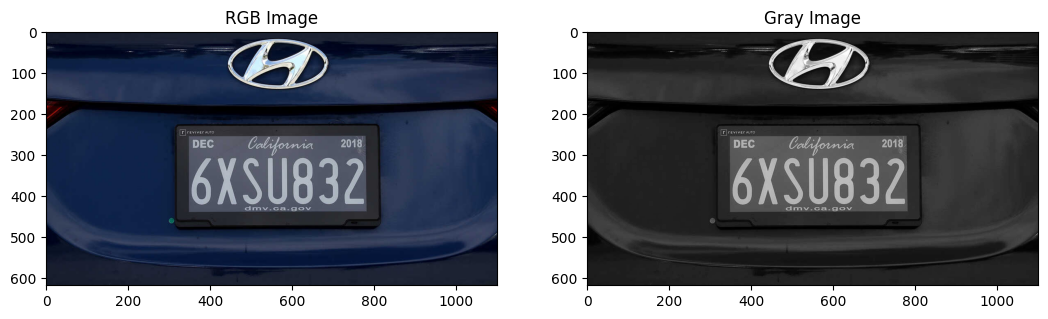

In [7]:
img = io.imread('imgs/License1.jpg')
gray_img = rgb2gray(img)
show_images([img,gray_img],titles=['RGB Image','Gray Image'])